YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  10 of 10 completed
[*********************100%***********************]  6 of 6 completed
C:\Users\PC\AppData\Local\Temp\ipykernel_33812\1414461046.py:76: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  t_bill_dataframe = t_bill_dataframe.reindex(index).fillna(method='ffill')
[*********************100%***********************]  1 of 1 completed
C:\Users\PC\AppData\Local\Temp\ipykernel_33812\1414461046.py:424: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  benchmark = benchmark.reindex(portfolio_returns.index).fillna(method='ffill')


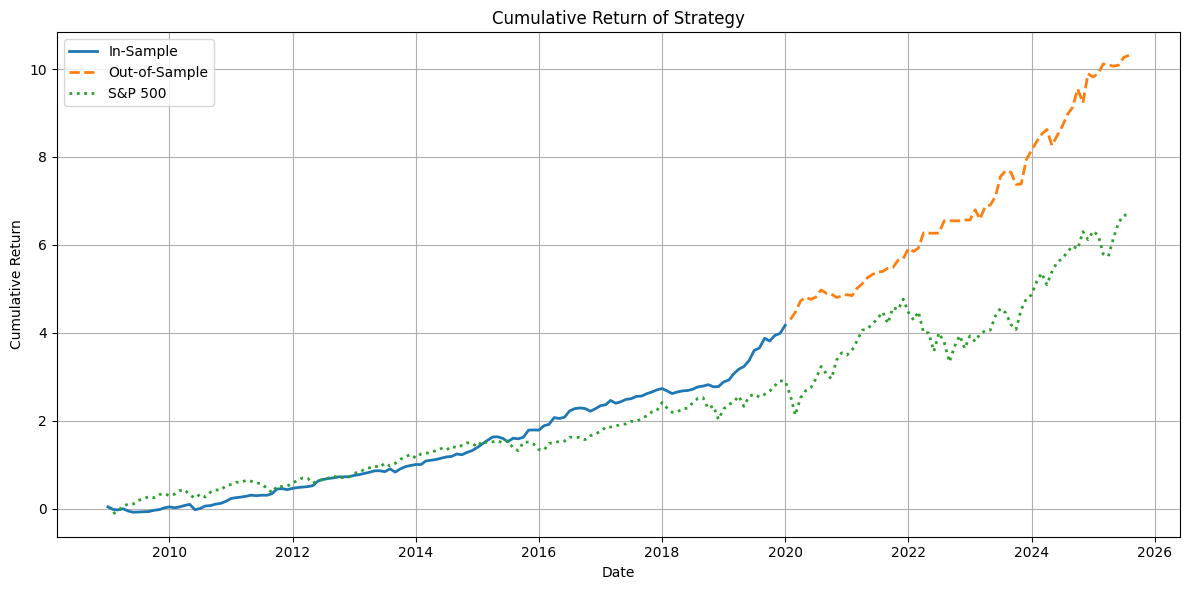

In-sample performance:
       CAGR  Annual Return  Annual Volatility  Sharpe Ratio
0  0.159872       0.152607           0.082281      1.789544

Out-of-sample performance:
      CAGR  Annual Return  Annual Volatility  Sharpe Ratio
0  0.15037       0.143452           0.072461      1.605053

=== 현재 시점 (2025-08-01) Regime ===
MM

=== Regime별 최적 비중 ===
       stock_weight bond_weight
regime                         
HH             0.0%      100.0%
HL            41.9%       58.1%
HM           100.0%        0.0%
LH             0.0%      100.0%
LL           83.58%      16.42%
LM           73.41%      26.59%
MH             0.0%      100.0%
ML           41.78%      58.22%
MM           41.05%      58.95%

=== 최종 주식 ETF 비중 ===
Ticker
XLB      0.0%
XLC    21.58%
XLE      0.0%
XLF    14.36%
XLI    15.32%
XLK    17.77%
XLP      0.0%
XLU    13.81%
XLV      0.0%
XLY    17.16%
Name: 2025-08-01 00:00:00, dtype: object

=== 최종 채권 ETF 비중 ===
Ticker
HYG    41.23%
IEF     7.13%
LQD    13.08%
SHY    20.18%
TIP

KeyError: "None of ['ETF'] are in the columns"

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from scipy.optimize import minimize
from pandas_datareader import data as web
import yfinance as yf
import requests
from bs4 import BeautifulSoup
import os

# 데이터 수집 클래스
class DataFetcher:
    def __init__(self, start_date, end_date):
        self.start_date = start_date
        self.end_date   = end_date

    # CLI와 VIX 지수 데이터 수집
    def fetch_cli_vix(self):
        cli_dataframe = web.DataReader('USALOLITOAASTSAM', 'fred',
                                    start=self.start_date, end=self.end_date)
        cli_dataframe = cli_dataframe.rename(columns={'USALOLITOAASTSAM': 'cli'})

        vix_daily = web.DataReader('VIXCLS', 'fred',
                                start=self.start_date, end=self.end_date)
        vix_monthly = vix_daily.resample('MS').first().rename(columns={'VIXCLS': 'vix'})
            
        last_vix_date = vix_daily['VIXCLS'].last_valid_index()
        last_vix_value = vix_daily.loc[last_vix_date, 'VIXCLS']
        latest_month_start_price = last_vix_date.to_period('M').to_timestamp()
        
        vix_monthly.loc[latest_month_start_price] = last_vix_value
        vix_monthly = vix_monthly.sort_index()

        
        cli_last_date = cli_dataframe.index.max()
        lagging = (last_vix_date.to_period('M') - cli_last_date.to_period('M')).n

        cli_dataframe = cli_dataframe.reindex(vix_monthly.index)
        cli_dataframe['cli'] = cli_dataframe['cli'].ffill(limit=2)
        
        return cli_dataframe, vix_monthly, lagging

    def fetch_current_prices(self, tickers):
        data = yf.download(tickers, period='1d', interval='1m', progress=False)
        if isinstance(data, pd.DataFrame) and 'Close' in data:
            latest_prices = data['Close'].iloc[-1]
            prices = {}
            for ticker in tickers:
                price = latest_prices.get(ticker, np.nan)
                prices[ticker] = round(price, 2) if not np.isnan(price) else None
            return prices
        else:
            return {ticker: None for ticker in tickers}#데이터가 유효하지 않으면, 모든 티커에 대해 None 반환
        
    def get_usd_krw_rate(self):
        ticker = yf.Ticker("KRW=X")
        data = ticker.history(period="1d")
        if not data.empty:
            return data['Close'].iloc[-1]#가장 마지막 시점(최신)의 종가 데이터만 추출
        else:
            raise ValueError("Failed to retrieve USD/KRW exchange rate.")

    # ETF 가격 데이터 수집
    def fetch_etf_data(self, tickers, test_start, test_end):
        etf_prices = yf.download(tickers, test_start, test_end)
        return etf_prices

    # 무위험 수익률 (3개월 T-bill 금리) 수집
    def fetch_tbill(self, index):
        t_bill_dataframe = web.DataReader('TB3MS','fred', index[0], index[-1])
        t_bill_dataframe = t_bill_dataframe.resample('MS').first()
        t_bill_dataframe['risk_free_rate'] = t_bill_dataframe['TB3MS'] / 100 / 12
        t_bill_dataframe = t_bill_dataframe[['risk_free_rate']]
        t_bill_dataframe.index = t_bill_dataframe.index.to_period('M').to_timestamp()
        t_bill_dataframe = t_bill_dataframe.reindex(index).fillna(method='ffill')
        return t_bill_dataframe

# Regime 분류 클래스
class RegimeClassifier:
    def __init__(self, cli_dataframe, vix_monthly):
        self.cli_dataframe = cli_dataframe
        self.vix_monthly = vix_monthly

    def classify(self):
        
        cli_year_over_year = np.log(self.cli_dataframe / self.cli_dataframe.shift(12)) * 100
        cli_year_over_year.rename(columns={'cli':'cli_yoy'}, inplace=True)
        vix_year_over_year = np.log(self.vix_monthly / self.vix_monthly.shift(12)) * 100
        vix_year_over_year.rename(columns={'vix':'vix_yoy'}, inplace=True)

        combined = pd.concat(
            [self.cli_dataframe, self.vix_monthly,
             cli_year_over_year, vix_year_over_year],
            axis=1
        ).dropna()

        growth_categories = []
        volatility_categories = []
        regime_dates = []
        for current_date in combined.index:
            hist_end = current_date - pd.offsets.MonthBegin(1)
            cli_hist = combined.loc[:hist_end, 'cli_yoy']
            vix_hist = combined.loc[:hist_end, 'vix_yoy']
            if len(cli_hist) < 36 or len(vix_hist) < 36:    #dynamic thresholding
                continue
            # 36개가 넘으면 다음 코드 실행
            lower_growth, upper_growth = cli_hist.quantile([1/3, 2/3])
            lower_volatility, upper_volatility = vix_hist.quantile([1/3, 2/3])
            current_cli = combined.at[current_date, 'cli_yoy']
            current_vix = combined.at[current_date, 'vix_yoy']
            # 라벨링
            growth_categories.append(
                'L' if current_cli <= lower_growth
                else 'M' if current_cli <= upper_growth
                else 'H'
            )
            volatility_categories.append(
                'L' if current_vix <= lower_volatility
                else 'M' if current_vix <= upper_volatility
                else 'H'
            )
            regime_dates.append(current_date)

        regime_dataframe = pd.DataFrame({
            'Growth': growth_categories,
            'Volatility': volatility_categories
        }, index=regime_dates)
        regime_dataframe['regime'] = regime_dataframe['Growth'] + regime_dataframe['Volatility']
        merged = combined.merge(
            regime_dataframe['regime'],
            left_index=True, right_index=True, how='left'
        )

        return merged.iloc[36:]
# quantile([1/3, 2/3]) 같은 분위수 기준 분류를 하기 위해 최소 36개월을 확보하는 것.


# 모멘텀 계산 클래스 (순수 모멘텀)
# Since backtest is based on month-end, use the month-start data without applying 1-month shift
class MomentumCalculator:
    @staticmethod
    def compute_momentum_score(price_dataframe, lagging=1):
        monthly_prices = price_dataframe['Close'].resample('MS').last()
        monthly_returns = monthly_prices.pct_change()
        if lagging == 1:
            momentum = (
                (1 + monthly_returns)
                .rolling(window=12)
                .apply(np.prod, raw=True)
            ) - 1
        elif lagging == 2:
            momentum = (
                (1 + monthly_returns.shift(1))
                .rolling(window=11)
                .apply(np.prod, raw=True)
            ) - 1
        else:
            raise ValueError("lagging must be either 1 or 2")

        return momentum

# 가중치 계산 클래스
class WeightAllocator:
    @staticmethod
    def get_weights(momentum_scores):
        raw_weights = momentum_scores.div(momentum_scores.sum(axis=1), axis=0)
        return raw_weights.fillna(0)

# 포트폴리오 시뮬레이션 클래스
class PortfolioSimulator:
    def __init__(self, stock_tickers, bond_tickers,
                 stock_price_data, bond_price_data,
                 stock_weights, bond_weights,
                 cli_vix_dataframe, transaction_cost=0.001):
        self.stock_tickers = stock_tickers
        self.bond_tickers = bond_tickers
        self.stock_price_data = stock_price_data
        self.bond_price_data = bond_price_data
        self.stock_weights = stock_weights
        self.bond_weights = bond_weights
        self.cli_vix_dataframe = cli_vix_dataframe
        self.transaction_cost = transaction_cost

    def monthly_start_return(self, price_data):
        month_start_price = price_data['Close'].resample('MS').first()
        return month_start_price.pct_change()

    def simulate(self):
        stock_returns = self.monthly_start_return(self.stock_price_data)
        bond_returns = self.monthly_start_return(self.bond_price_data)

        weighted_stock_returns = stock_returns.mul(
            self.stock_weights.iloc[:, :-1]
        ).sum(axis=1)
        weighted_bond_returns = bond_returns.mul(
            self.bond_weights.iloc[:, :-1]
        ).sum(axis=1)

        df = pd.DataFrame({
            'stock_ret': weighted_stock_returns,
            'bond_ret' : weighted_bond_returns
        })
        df['stock_weight_change'] = self.stock_weights['stock_weight_change']
        df['bond_weight_change']  = self.bond_weights['bond_weight_change']

        regime_index = self.cli_vix_dataframe.index.to_period('M').to_timestamp()
        df = df.merge(
            self.cli_vix_dataframe[['regime']].reindex(regime_index),
            left_index=True, right_index=True
        )
        return df

    @staticmethod
    def optimize_by_regime(df, lambda_var=0.05, tc=0.001):
        def objective(weights,
                    stock_ret_series,
                    bond_ret_series,
                    risk_free_series,
                    stock_weight_change_series,
                    bond_weight_change_series):
            
            # 포트폴리오 수익률 및 비용
            portfolio_return = (
                weights[0] * stock_ret_series +
                weights[1] * bond_ret_series
            )
            transaction_costs = tc * (
                weights[0] * stock_weight_change_series +
                weights[1] * bond_weight_change_series
            )
            net_excess_return = portfolio_return - risk_free_series - transaction_costs

            # 위험조정 수익률(Sharpe) 및 분산 패널티
            sharpe_ratio = np.mean(net_excess_return) / np.std(portfolio_return)
            variance_penalty = np.var(portfolio_return)

            # 목적함수: Sharpe 최대화 - Variance 패널티
            return -sharpe_ratio + lambda_var * variance_penalty

        results = []

        # regime별 최적화 수행
        for regime_label, group in df.groupby('regime'):
            res = minimize(
                objective,
                x0=[0.5, 0.5],
                args=(
                    group['stock_ret'],
                    group['bond_ret'],
                    group['risk_free_rate'],
                    group['stock_weight_change'],
                    group['bond_weight_change']
                ),
                bounds=[(0, 1), (0, 1)],
                constraints={'type': 'eq', 'fun': lambda w: w.sum() - 1}
            )

            results.append({
                'regime': regime_label,
                'stock_weight': res.x[0],
                'bond_weight': res.x[1]
            })

        return pd.DataFrame(results)
    
    
    @staticmethod
    def performance_metrics(df, label='strategy_return'):
        subset = df.dropna(subset=[label]).copy()

        years = len(subset) / 12
        cagr = (1 + subset[label]).prod()**(1/years) - 1
        annual_return = subset[label].mean() * 12
        annual_volatility = subset[label].std() * np.sqrt(12)
        sharpe_ratio = (
            annual_return -
            subset['risk_free_rate'].mean() * 12
        ) / annual_volatility

        return pd.DataFrame({
            'CAGR': [cagr],
            'Annual Return': [annual_return],
            'Annual Volatility': [annual_volatility],
            'Sharpe Ratio': [sharpe_ratio]
        })

# Modified Duration 및 DV01 계산 클래스
class DV01Calculator:
    def __init__(self, bond_tickers):
        self.bond_tickers = bond_tickers
        self.etf_urls = {
            'TLT': 'https://www.ishares.com/us/products/239454/',
            'IEF': 'https://www.ishares.com/us/products/239458/',
            'SHY': 'https://www.ishares.com/us/products/239466/',
            'TIP': 'https://www.ishares.com/us/products/239467/',
            'LQD': 'https://www.ishares.com/us/products/239566/',
            'HYG': 'https://www.ishares.com/us/products/239565/'
        }
        self.cache_file = 'duration_cache.csv'
        self.cache_expiry_days = 7

    def get_modified_durations(self):
        if os.path.exists(self.cache_file):
            df = pd.read_csv(self.cache_file, index_col=0, parse_dates=['last_updated'])
            if (datetime.today() - df['last_updated'].max()).days <= self.cache_expiry_days:
                print("[INFO] 캐시된 Modified Duration 데이터를 사용합니다.")
                return df.drop(columns='last_updated')

        print("[INFO] 웹에서 Modified Duration을 재크롤링합니다.")
        results = []
        for etf in self.bond_tickers:
            url = self.etf_urls.get(etf, '')
            if not url:
                continue
            duration = self._crawl_duration(etf, url)
            if duration is not None:
                results.append({
                    'ETF': etf,
                    'Modified Duration': duration,
                    '1bp Rate Sensitivity (%)': round(duration * 0.01, 4)
                })

        df = pd.DataFrame(results).set_index('ETF')
        df['last_updated'] = datetime.today()
        df.to_csv(self.cache_file)
        return df.drop(columns='last_updated')

    def _crawl_duration(self, etf, url):
        headers = {'User-Agent': 'Mozilla/5.0'}
        try:
            res = requests.get(url, headers=headers, timeout=10)
            res.raise_for_status()
            soup = BeautifulSoup(res.text, 'html.parser')
            for row in soup.find_all('tr'):
                if 'Modified Duration' in row.text:
                    val = row.find_all('td')[-1].text.strip().replace('years', '').strip()
                    return float(val)
        except Exception as e:
            print(f"[ERROR] {etf} 크롤링 실패: {e}")
            return None

    def get_latest_prices(self):
        end = datetime.today()
        start = end - timedelta(days=10)
        data = yf.download(self.bond_tickers, start=start.strftime('%Y-%m-%d'), end=end.strftime('%Y-%m-%d'))
        return data['Close'].ffill().iloc[-1]

    def compute_dv01(self, durations, prices):
        durations['Price'] = prices
        durations['DV01 ($)'] = durations['Modified Duration'] * durations['Price'] * 0.0001 #dv01 계산 공식 사용용
        return durations[['Modified Duration', 'Price', 'DV01 ($)']]

# 시각화 클래스
class Visualizer:
    @staticmethod
    def plot_cumulative_return(in_sample, out_sample, benchmark=None):
        plt.figure(figsize=(12,6))
        plt.plot(in_sample, label='In-Sample', linewidth=2)
        plt.plot(out_sample, label='Out-of-Sample',
                 linestyle='--', linewidth=2)
        if benchmark is not None:
            plt.plot(benchmark, label='S&P 500',
                     linestyle=':', linewidth=2)
        plt.title('Cumulative Return of Strategy')
        plt.xlabel('Date')
        plt.ylabel('Cumulative Return')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

# 전체 실행 통합 클래스
class RegimeBasedAssetAllocator:
    def __init__(self):
        # 초기 설정: 데이터 수집 기간 및 자산 티커
        self.start_date     = '1992-01-01'
        self.end_date       = datetime.today().strftime('%Y-%m-%d')
        self.stock_tickers  = ["XLK","XLF","XLV","XLY", "XLP","XLI","XLE","XLB","XLU","XLC"]
        self.bond_tickers   = ["TLT","IEF","SHY","TIP","LQD","HYG"]
        self.test_start     = "2008-01-01"
        self.test_end       = self.end_date
        self.momentum_start = pd.to_datetime(self.test_start) + pd.DateOffset(months=12)

    def run(self):
        # (1) CLI 및 VIX 지수 데이터를 수집하고 Regime 분류
        fetcher = DataFetcher(self.start_date, self.end_date)
        cli_df, vix_monthly, lagging = fetcher.fetch_cli_vix()
        cli_vix_df = RegimeClassifier(cli_df, vix_monthly).classify()

        # (2) ETF 가격 데이터 수집
        stock_data = fetcher.fetch_etf_data(self.stock_tickers, self.test_start, self.test_end)
        bond_data  = fetcher.fetch_etf_data(self.bond_tickers, self.test_start, self.test_end)

        # (3) 모멘텀 점수 계산 (양수일 때만 유지)
        stock_momentum = MomentumCalculator.compute_momentum_score(stock_data, lagging).resample('MS').last().loc[self.momentum_start:]
        bond_momentum  = MomentumCalculator.compute_momentum_score(bond_data, lagging).resample('MS').last().loc[self.momentum_start:]
        stock_momentum[stock_momentum < 0] = 0 #음수는 0으로 처리
        bond_momentum[bond_momentum < 0]   = 0

        # (4) 가중치 계산 및 변동성(리밸런싱 정도) 추정
        stock_weights = WeightAllocator.get_weights(stock_momentum)
        bond_weights  = WeightAllocator.get_weights(bond_momentum)
        stock_weights['stock_weight_change'] = stock_weights.diff().abs().sum(axis=1)
        bond_weights['bond_weight_change']  = bond_weights.diff().abs().sum(axis=1)

        # (5) 포트폴리오 시뮬레이션 실행
        portfolio_returns = PortfolioSimulator(
            self.stock_tickers, self.bond_tickers,
            stock_data, bond_data,
            stock_weights, bond_weights,
            cli_vix_df,
            transaction_cost=0.001
        ).simulate()

        # (6) 무위험 수익률 추가
        t_bill_df = fetcher.fetch_tbill(portfolio_returns.index)
        portfolio_returns = portfolio_returns.drop(columns=['risk_free_rate'], errors='ignore').merge(t_bill_df, left_index=True, right_index=True)

        # (7) 벤치마크 수익률(S&P 500) 생성
        benchmark_start = pd.to_datetime(self.test_start) + pd.DateOffset(months=12)
        sp500 = fetcher.fetch_etf_data(['^GSPC'], benchmark_start.strftime('%Y-%m-%d'), self.test_end)
        benchmark = sp500['Close'].resample('MS').last().pct_change().add(1).cumprod().sub(1)
        benchmark = benchmark.reindex(portfolio_returns.index).fillna(method='ffill')

        # (8) 인샘플/아웃샘플 분리 기준 설정
        split_date      = '2020-01-01'
        oos_start_date  = (pd.to_datetime(split_date) + pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        in_sample_df    = portfolio_returns.loc[:split_date]
        out_sample_df   = portfolio_returns.loc[oos_start_date:]

        # (9) regime별 최적 비중 계산 (Sharpe 최대화 + 분산 패널티 최소화)
        optimal_weights = PortfolioSimulator.optimize_by_regime(in_sample_df)
        portfolio_returns = portfolio_returns.join(optimal_weights.set_index('regime'), on='regime')

        # (10) 전략 수익률 계산
        tc = 0.001
        portfolio_returns['strategy_return'] = (
            portfolio_returns['stock_ret'] * portfolio_returns['stock_weight'] +
            portfolio_returns['bond_ret']  * portfolio_returns['bond_weight'] -
            (portfolio_returns['stock_weight_change'] * portfolio_returns['stock_weight'] +
             portfolio_returns['bond_weight_change']  * portfolio_returns['bond_weight']) * tc
        )
        portfolio_returns['cumulative_return'] = (1 + portfolio_returns['strategy_return']).cumprod() - 1

        # (11) 성과 시각화 및 지표 출력
        Visualizer.plot_cumulative_return(
            portfolio_returns.loc[:split_date, 'cumulative_return'],
            portfolio_returns.loc[oos_start_date:, 'cumulative_return'],
            benchmark=benchmark
        ) # 함수 파라미터 명과 benchmark 를 넘김
        
        print("In-sample performance:")
        print(PortfolioSimulator.performance_metrics(portfolio_returns.loc[:split_date]))
        print("\nOut-of-sample performance:")
        print(PortfolioSimulator.performance_metrics(portfolio_returns.loc[oos_start_date:]))

        # (12) 현재 regime 정보 출력
        latest_date = portfolio_returns.index[-1]
        current_regime = portfolio_returns.loc[latest_date, 'regime']
        print(f"\n=== 현재 시점 ({latest_date.strftime('%Y-%m-%d')}) Regime ===")
        print(current_regime)

        # (13) Regime별 최적 주식/채권 비중 출력
        regime_weights_df = optimal_weights.set_index('regime').copy()
        regime_weights_df['stock_weight'] = (regime_weights_df['stock_weight'] * 100).round(2).astype(str) + '%'
        regime_weights_df['bond_weight'] = (regime_weights_df['bond_weight'] * 100).round(2).astype(str) + '%'
        print("\n=== Regime별 최적 비중 ===")
        print(regime_weights_df)

        # (14) 리밸런싱 기준 최종 비중 출력
        final_stock_weights = stock_weights.iloc[-1].drop('stock_weight_change').mul(100).round(2).astype(str) + '%'
        final_bond_weights  = bond_weights.iloc[-1].drop('bond_weight_change').mul(100).round(2).astype(str) + '%'
        print("\n=== 최종 주식 ETF 비중 ===")
        print(final_stock_weights)
        print("\n=== 최종 채권 ETF 비중 ===")
        print(final_bond_weights)

        # (15) 채권 DV01 계산 및 출력
        dv01_calc = DV01Calculator(self.bond_tickers)
        durations = dv01_calc.get_modified_durations()
        prices = dv01_calc.get_latest_prices()
        dv01_result = dv01_calc.compute_dv01(durations, prices)
        print("\n=== 채권 ETF별 Modified Duration, Price, DV01 ===")
        print(dv01_result)

        # (16) 현재 ETF 가격 조회
        current_prices = fetcher.fetch_current_prices(self.stock_tickers + self.bond_tickers)

        # (17) 자산별 달러 배분액 계산 및 비중 적용
        total_krw = 100_000_000 
        usd_krw_rate = fetcher.get_usd_krw_rate()
        total_usd = total_krw / usd_krw_rate
        stock_weight_ratio = float(optimal_weights.set_index('regime').loc[current_regime, 'stock_weight'])
        bond_weight_ratio  = float(optimal_weights.set_index('regime').loc[current_regime, 'bond_weight'])
        final_stock_weights_float = stock_weights.drop(columns='stock_weight_change').iloc[-1]
        final_bond_weights_float  = bond_weights.drop(columns='bond_weight_change').iloc[-1]

        allocation = {}
        for ticker in self.stock_tickers:
            weight = final_stock_weights_float[ticker]
            allocation[ticker] = round(total_usd * stock_weight_ratio * weight, 2)
        for ticker in self.bond_tickers:
            weight = final_bond_weights_float[ticker]
            allocation[ticker] = round(total_usd * bond_weight_ratio * weight, 2)

        allocation_df = pd.DataFrame.from_dict(allocation, orient='index', columns=['Allocated Amount ($)'])
        allocation_df.index.name = 'Ticker'

        # (18) ETF 별 최신 가격 기준으로 매입 수량 추정
        current_prices_series = pd.Series(current_prices)
        allocation_df['Current Price ($)'] = current_prices_series
        allocation_df['Number of Securities'] = (allocation_df['Allocated Amount ($)'] / allocation_df['Current Price ($)']).round(2)

        print("\n=== ETF Allocation: Dollar Amounts + Estimated Number of Shares ===")
        print(f"Allocated KRW: \u20a9{total_krw} (USD: ${total_usd:,.2f})")
        print(allocation_df.sort_values(by='Allocated Amount ($)', ascending=False).to_string())



#--------------------------------엑셀---------------------------------------------------------
        # (19) 엑셀로 결과 저장 - 날짜 포함 + 수치형 비중
        today_str = datetime.today().strftime('%Y%m%d')
        desktop_path = os.path.join(os.path.expanduser("~"), "Desktop")
        #file_name = f"regime_allocation_report_{today_str}.xlsx"
        file_name = os.path.join(desktop_path, f"regime_allocation_report_{today_str}.xlsx")
        #stock / bond 비중 숫자형으로 다시 준비
        final_stock_weights_numeric = stock_weights.iloc[-1].drop('stock_weight_change')
        final_bond_weights_numeric = bond_weights.iloc[-1].drop('bond_weight_change')

        with pd.ExcelWriter(file_name, engine="openpyxl") as writer:
             # 성과지표
            PortfolioSimulator.performance_metrics(portfolio_returns.loc[:split_date]).to_excel(writer, sheet_name="In-sample")
            PortfolioSimulator.performance_metrics(portfolio_returns.loc[oos_start_date:]).to_excel(writer, sheet_name="Out-of-sample")

            # Regime별 최적 비중
            optimal_weights.to_excel(writer, sheet_name="Optimal Regime Weights")

            # 주식/채권 ETF 최종 비중 (숫자형)
            final_stock_weights_numeric.to_frame(name="Weight").to_excel(writer, sheet_name="Stock Weights")
            final_bond_weights_numeric.to_frame(name="Weight").to_excel(writer, sheet_name="Bond Weights")

            # DV01 결과
            dv01_result.to_excel(writer, sheet_name="Bond DV01")

            # ETF 배분 현황
            allocation_df.to_excel(writer, sheet_name="ETF Allocation")

            # 총 투자금 및 환율 정보 저장 (우측 공간에 추가)
            info_df = pd.DataFrame({
            'Allocated KRW': [f"₩{total_krw:,}"],
            'Allocated USD': [f"${total_usd:,.2f}"],
            'USD/KRW Rate': [f"{usd_krw_rate:,.2f}"]
             })
            info_df.to_excel(writer, sheet_name="ETF Allocation", startrow=0, startcol=6, index=False)

        print(f"\n[INFO] 결과가 '{file_name}' 파일로 저장되었습니다.")

#--------------------------------------------------------------------------------------------------------------

if __name__ == "__main__":
    RegimeBasedAssetAllocator().run()
